<div style="text-align: right"> __ Provided on May 27 and due on June 17__ [BRI516, Spring/2019] </div>

#### [Hw05] Implementing a Multilayer Neural Networks using TensorFlow (TF) 1.x (Ch. 13)


##### (1) Data preparation
    (1a) Load the train dataset and test dataset of the MNIST 
    
    (1b) Set the first 55,000 samples in the training dataset as training data, the remaining 5,000 samples in the training dataset as validation data, and 10,000 samples in the test dataset as test data.

<br><br>

##### (2) Multilayer perceptron (MLP) using the low-level API of TF (e.g., p. 429)
    (2a) Implement the multilayer perceptron (MLP) with two hidden layers for classification, and evaluate performance in the following scenarios
    
        (2a-1) for a few choices of hidden nodes per hidden layer
        
        (2a-2) for a few choices of activation functions (i.e., sigmoid, tanh, and ReLU)
    
    (2b) Add the L2-norm regularization of weights to (2a) and evalute performance for a few choices of L2-norm regularization parameters. For this, please pick the best-performing model from (2a)

    (2c) Evaluate the performance of (2b) for a few options of mini-batch sizes 
    
    (2d) Commonly for the results for (2a) - (2c), discuss the results such as by presenting convergence curves of cost and/or accuracy and by exemplifying the misclassified digits
    

# 1. Data preperation
## Define libraries and function to load the data set

In [2]:
import numpy as np
import tensorflow as tf
import os
import struct
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, accuracy_score
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import roc_auc_score, accuracy_score


def load_mnist_data(path, kind='train'):
    labels_path = os.path.join(path, '%s-labels.idx1-ubyte' % kind)
    images_path = os.path.join(path, '%s-images.idx3-ubyte' % kind)
    
    with open(labels_path, 'rb') as lbpath:
        magic, n = struct.unpack('>II', lbpath.read(8))
        labels = np.fromfile(lbpath, dtype=np.uint8)
        
        with open(images_path, 'rb') as imgpath:
            magic, num, rows, cols = struct.unpack(">IIII", imgpath.read(16))
            images = np.fromfile(imgpath, dtype=np.uint8).reshape(len(labels),784)
            images = images.astype(float) / 255.
            
        return images, labels
    


## Load the dataset and prepare

In [3]:
def load_and_split_data():
    X_train_temp, y_train_temp = load_mnist_data('',kind = 'train')
    X_train = X_train_temp[:55000]
    y_train = y_train_temp[:55000]
    lb = LabelBinarizer()
    y_train = lb.fit_transform(y_train)
    print('Training set: Rows: %d, columns: %d'
         % (X_train.shape[0], X_train.shape[1]))
    
    X_validation = X_train_temp[55000:]
    y_validation = y_train_temp[55000:]
    y_validation = lb.fit_transform(y_validation)
    print('Validation set: Rows: %d, columns: %d'
         % (X_validation.shape[0], X_validation.shape[1]))
    
    
    X_test, y_test = load_mnist_data('', kind='t10k')
    y_test = lb.fit_transform(y_test)
    print('Test set: Rows: %d, columns: %d'
         % (X_test.shape[0], X_test.shape[1]))
    
    
    return X_train, y_train, X_validation, y_validation, X_test, y_test




# 2) Multilayer perceptron (MLP) using the low-level API of TF

## 2a)


In [29]:
# For activiation_method_hidden_layer you can either choose 'relu' (which is default), 'tanh' or 'sigmoid'.
# If an unsupported activation method gots passed, then ReLu (the default) will be taken.
class MLP:
    
    def __init__(self, num_features, num_output,
                 num_layers_0 = 512, num_layers_1 = 256,
                 start_learning_rate=0.001,
                 activiation_method_hidden_layer = "relu",
                 l2_regulation_strength = 0):
        self.num_output = num_output
        self.num_features = num_features
        self.num_layers_0 = num_layers_0
        self.num_layers_1 = num_layers_1
        self.start_learning_rate = start_learning_rate
        self.activiation_method_hidden_layer = activiation_method_hidden_layer 
        self.l2_regulation_strength = l2_regulation_strength
        #Graph
        self.g = tf.Graph()
        with self.g.as_default():
            self.build()
            self.init_op = tf.global_variables_initializer()
    def build(self):        
        
        
        self.X = tf.placeholder(dtype=tf.float32, shape=(None, self.num_features), name='X')
        self.y = tf.placeholder(dtype=tf.float32, shape=(None, self.num_output), name='y')
        
        ########################
        # Weight initialization by random normal function with std_dev = 1/sqrt(number of input features)
        ########################
        
        weights_0 = tf.Variable(tf.random_normal([self.num_features,self.num_layers_0], stddev=(1/tf.sqrt(float(self.num_features)))))
        bias_0 = tf.Variable(tf.random_normal([self.num_layers_0]))
        weights_1 = tf.Variable(tf.random_normal([self.num_layers_0,self.num_layers_1], stddev=(1/tf.sqrt(float(self.num_layers_0)))))
        bias_1 = tf.Variable(tf.random_normal([self.num_layers_1]))
        weights_2 = tf.Variable(tf.random_normal([self.num_layers_1,self.num_output], stddev=(1/tf.sqrt(float(self.num_layers_1)))))
        bias_2 = tf.Variable(tf.random_normal([self.num_output]))
        
        ########################
        # Hidden Layers sigmoid, tanh or relu
        ########################
        if(self.activiation_method_hidden_layer == 'sigmoid'):
            hidden_output_0 = tf.nn.sigmoid(tf.matmul(self.X,weights_0)+bias_0)
            hidden_output_1 = tf.nn.sigmoid(tf.matmul(hidden_output_0,weights_1)+bias_1) 
        else:
            if(self.activiation_method_hidden_layer == "tanh"):                
                hidden_output_0 = tf.nn.tanh(tf.matmul(self.X,weights_0)+bias_0)
                hidden_output_1 = tf.nn.tanh(tf.matmul(hidden_output_0,weights_1)+bias_1) 
            else:
                hidden_output_0 = tf.nn.relu(tf.matmul(self.X,weights_0)+bias_0)
                hidden_output_1 = tf.nn.relu(tf.matmul(hidden_output_0,weights_1)+bias_1)   

        
        self.predicted_y = tf.sigmoid(tf.matmul(hidden_output_1,weights_2) + bias_2)
    
        self.loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=self.predicted_y,labels=self.y)) \
                + (self.l2_regulation_strength*tf.reduce_sum(tf.square(bias_1)))
        
        ## Decrease the learning rate after each 5 epochs by 15% for better performance 
        learning_rate = tf.train.exponential_decay(self.start_learning_rate, 0, 5, 0.85, staircase=True)
        ## Adam optimzer for finding the right weight
        self.optimizer = tf.train.AdamOptimizer(learning_rate).minimize(self.loss,var_list=[weights_0,weights_1,weights_2,
                                                                                 bias_0,bias_1,bias_2])
        
        correct_prediction = tf.equal(tf.argmax(y_train,1), tf.argmax(self.predicted_y,1))
        self.accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))




## Train function

In [13]:
def train_mlp(sess, model, X_train, y_train, X_test, y_test, num_epochs=10, batch_size = 128):
    ## initialiaze all variables: W and b
    sess.run(model.init_op)
    train_accuracy = []
    train_cost = []
    test_accuracy= []
    for i in range(num_epochs):
        arr = np.arange(X_train.shape[0])
        np.random.shuffle(arr)
        #batch loop
        cost_temp = 0
        for index in range(0,X_train.shape[0],batch_size):
            sess.run(model.optimizer,
                                           {model.X: X_train[arr[index:index+batch_size]],
                                            model.y: y_train[arr[index:index+batch_size]]})
    
        train_accuracy_temp = sess.run(model.accuracy, feed_dict =  {model.X:X_train, model.y: y_train})
        test_accuracy_temp = accuracy_score(y_test.argmax(1), sess.run(model.predicted_y, {model.X: X_test}).argmax(1))
        cost_temp =  sess.run(model.loss, {model.X: X_train,model.y: y_train})
        #print("Costs/Loss: {0:.6f} ---- {2:5f} Accuracy {1:.5f}".format((cost_temp*cost_temp*cost_temp),train_accuracy_temp,test_accuracy_temp))
        
        train_accuracy.append(train_accuracy_temp)
        train_cost.append(cost_temp)
        test_accuracy.append(test_accuracy_temp)
    return train_accuracy, train_cost, test_accuracy


## Load dataset

In [6]:
X_train, y_train, X_val, y_val, X_test, y_test = load_and_split_data()


Training set: Rows: 55000, columns: 784
Validation set: Rows: 5000, columns: 784
Test set: Rows: 10000, columns: 784


# 2a) - 1 Testing different node sizes

In [46]:
model = MLP(num_output = y_train.shape[1],
            num_features = X_train.shape[1],
            num_layers_0 = 512,
            num_layers_1 = 256,
            start_learning_rate = 0.01)
sess = tf.Session(graph=model.g)

train_accuracy_1, train_cost_1, test_accuracy_1 = train_mlp(sess,model,X_train,y_train,X_test,y_test,
                                                       num_epochs = 12,
                                                       batch_size = X_train.shape[0])
print("Finished 1st Multilayer Perceptron")
model = MLP(num_output = y_train.shape[1],
            num_features = X_train.shape[1],
            num_layers_0 = 256,
            num_layers_1 = 128,
            start_learning_rate = 0.01)
sess = tf.Session(graph=model.g)

train_accuracy_2, train_cost_2, test_accuracy_2 = train_mlp(sess,model,X_train,y_train,X_test,y_test,
                                                       num_epochs = 12,
                                                       batch_size = X_train.shape[0])
print("Finished 2nd Multilayer Perceptron")
model = MLP(num_output = y_train.shape[1],
            num_features = X_train.shape[1],
            num_layers_0 = 128,
            num_layers_1 = 64,
            start_learning_rate = 0.01)
sess = tf.Session(graph=model.g)

train_accuracy_3, train_cost_3, test_accuracy_3 = train_mlp(sess,model,X_train,y_train,X_test,y_test,
                                                       num_epochs = 12,
                                                       batch_size = X_train.shape[0])
print("Finished 3rd Multilayer Perceptron")

Finished 1st Multilayer Perceptron
Finished 2nd Multilayer Perceptron
Finished 3rd Multilayer Perceptron


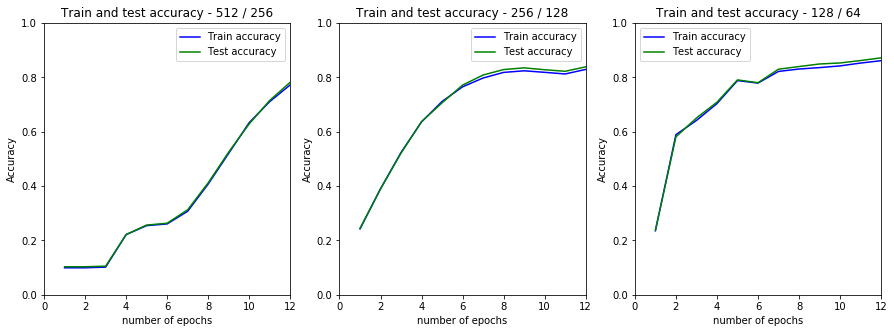

Last epoch of first plot:  Train accuracy 0.772436 Test accuracy 0.78210
Last epoch of second plot:  Train accuracy 0.829145 Test accuracy 0.83870
Last epoch of third plot:  Train accuracy 0.829145 Test accuracy 0.87180


In [47]:
#Plotting
plt.figure(figsize=(15,5))
K = range(1,13)

plt.subplot(1,3,1)
plt.plot(K, train_accuracy_1, color='blue', label='Train accuracy')
plt.plot(K, test_accuracy_1, color='green', label='Test accuracy')
plt.xlabel('number of epochs')
plt.ylabel('Accuracy')
plt.title('Train and test accuracy - 512 / 256')
plt.legend()
plt.axis([0, 12, 0, 1])

plt.subplot(1,3,2)
plt.plot(K, train_accuracy_2, color='blue', label='Train accuracy')
plt.plot(K, test_accuracy_2, color='green', label='Test accuracy')
plt.xlabel('number of epochs')
plt.ylabel('Accuracy')
plt.title('Train and test accuracy - 256 / 128')
plt.legend()
plt.axis([0, 12, 0, 1])


plt.subplot(1,3,3)
plt.plot(K, train_accuracy_3, color='blue', label='Train accuracy')
plt.plot(K, test_accuracy_3, color='green', label='Test accuracy')
plt.xlabel('number of epochs')
plt.ylabel('Accuracy')
plt.title('Train and test accuracy - 128 / 64')
plt.legend()
plt.axis([0, 12, 0, 1])
plt.show()

print("Last epoch of first plot:  Train accuracy {0:5f} Test accuracy {1:.5f}".format(train_accuracy_1[11],test_accuracy_1[11]))
print("Last epoch of second plot:  Train accuracy {0:5f} Test accuracy {1:.5f}".format(train_accuracy_2[11],test_accuracy_2[11]))
print("Last epoch of third plot:  Train accuracy {0:5f} Test accuracy {1:.5f}".format(train_accuracy_2[11],test_accuracy_3[11]))


### Comment
By comparing the graphs and the maximum accuracy after 12 epochs, then we can see that the second (256 / 128 ) and third (128 / 64) outperforms the first (512/256) MLP IN convergence speed. We could perform another experiment with more epochs which may change the maximum achieved accuracy. 
We can see in the thrid graph that their are big (edgy) changes. This makes sense, since we are reducing the initial dimension of > 700 to 128 in the first hidden layer.
I'll continue my further experiments with the 128 nodes for the first hidden layer and 64 for the second hidden layer.

# 2b) Testing different activation functions

In [48]:
model = MLP(num_output = y_train.shape[1],
            num_features = X_train.shape[1],
            num_layers_0 = 128,
            num_layers_1 = 64,
            start_learning_rate = 0.01,
            activiation_method_hidden_layer = "sigmoid")
sess = tf.Session(graph=model.g)

train_accuracy_1, train_cost_1, test_accuracy_1 = train_mlp(sess,model,X_train,y_train,X_test,y_test,
                                                       num_epochs = 12,
                                                       batch_size = X_train.shape[0])
print("Finished 1st Multilayer Perceptron")
model = MLP(num_output = y_train.shape[1],
            num_features = X_train.shape[1],
            num_layers_0 = 128,
            num_layers_1 = 64,
            start_learning_rate = 0.01,
            activiation_method_hidden_layer = "tanh")
sess = tf.Session(graph=model.g)

train_accuracy_2, train_cost_2, test_accuracy_2 = train_mlp(sess,model,X_train,y_train,X_test,y_test,
                                                       num_epochs = 12,
                                                       batch_size = X_train.shape[0])
print("Finished 2nd Multilayer Perceptron")
model = MLP(num_output = y_train.shape[1],
            num_features = X_train.shape[1],
            num_layers_0 = 128,
            num_layers_1 = 64,
            start_learning_rate = 0.01,
            activiation_method_hidden_layer = "relu")
sess = tf.Session(graph=model.g)

train_accuracy_3, train_cost_3, test_accuracy_3 = train_mlp(sess,model,X_train,y_train,X_test,y_test,
                                                       num_epochs = 12,
                                                       batch_size = X_train.shape[0])
print("Finished 3rd Multilayer Perceptron")

Finished 1st Multilayer Perceptron
Finished 2nd Multilayer Perceptron
Finished 3rd Multilayer Perceptron


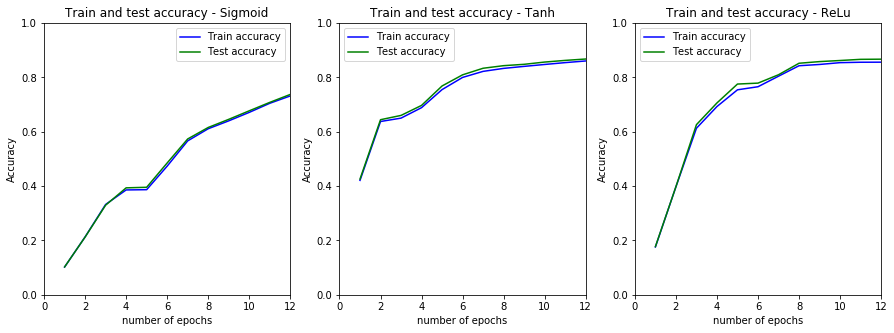

Last epoch of first plot:  Train accuracy 0.731636 Test accuracy 0.73720
Last epoch of second plot:  Train accuracy 0.860309 Test accuracy 0.86750
Last epoch of third plot:  Train accuracy 0.860309 Test accuracy 0.86690


In [49]:
#Plotting
plt.figure(figsize=(15,5))
K = range(1,13)

plt.subplot(1,3,1)
plt.plot(K, train_accuracy_1, color='blue', label='Train accuracy')
plt.plot(K, test_accuracy_1, color='green', label='Test accuracy')
plt.xlabel('number of epochs')
plt.ylabel('Accuracy')
plt.title('Train and test accuracy - Sigmoid')
plt.legend()
plt.axis([0, 12, 0, 1])

plt.subplot(1,3,2)
plt.plot(K, train_accuracy_2, color='blue', label='Train accuracy')
plt.plot(K, test_accuracy_2, color='green', label='Test accuracy')
plt.xlabel('number of epochs')
plt.ylabel('Accuracy')
plt.title('Train and test accuracy - Tanh')
plt.legend()
plt.axis([0, 12, 0, 1])


plt.subplot(1,3,3)
plt.plot(K, train_accuracy_3, color='blue', label='Train accuracy')
plt.plot(K, test_accuracy_3, color='green', label='Test accuracy')
plt.xlabel('number of epochs')
plt.ylabel('Accuracy')
plt.title('Train and test accuracy - ReLu')
plt.legend()
plt.axis([0, 12, 0, 1])
plt.show()

print("Last epoch of first plot:  Train accuracy {0:5f} Test accuracy {1:.5f}".format(train_accuracy_1[11],test_accuracy_1[11]))
print("Last epoch of second plot:  Train accuracy {0:5f} Test accuracy {1:.5f}".format(train_accuracy_2[11],test_accuracy_2[11]))
print("Last epoch of third plot:  Train accuracy {0:5f} Test accuracy {1:.5f}".format(train_accuracy_2[11],test_accuracy_3[11]))


### Comment
As we can see the Tanh and Relu activation function outperforms the sigmoid activiation function in speed and final accuracy after 12 epochs (it may achieve the same accuracy after many more epochs).
The tanh converges at the beginning more faster than Relu, but ReLu has even a slightly higher accuracy at 8 epochs. Nevertheless, both tanh and relu achieve very similar results after 12 epochs.
I'll continue my further experiments with tanh activation function.

# 2b) Adding L2 Regularization and testing different parameters.
Note that L2 is already implemented in the MLP class and can be activated by changing the default value of the parameter l2_regulation_strength from 0 to any number > 0

In [55]:
model = MLP(num_output = y_train.shape[1],
            num_features = X_train.shape[1],
            num_layers_0 = 128,
            num_layers_1 = 64,
            start_learning_rate = 0.01,
            activiation_method_hidden_layer = "tanh",
            l2_regulation_strength = 0.5)
sess = tf.Session(graph=model.g)

train_accuracy_1, train_cost_1, test_accuracy_1 = train_mlp(sess,model,X_train,y_train,X_test,y_test,
                                                       num_epochs = 12,
                                                       batch_size = X_train.shape[0])
print("Finished 1st Multilayer Perceptron")
model = MLP(num_output = y_train.shape[1],
            num_features = X_train.shape[1],
            num_layers_0 = 128,
            num_layers_1 = 64,
            start_learning_rate = 0.01,
            activiation_method_hidden_layer = "tanh",
           l2_regulation_strength = 1)
sess = tf.Session(graph=model.g)

train_accuracy_2, train_cost_2, test_accuracy_2 = train_mlp(sess,model,X_train,y_train,X_test,y_test,
                                                       num_epochs = 12,
                                                       batch_size = X_train.shape[0])
print("Finished 2nd Multilayer Perceptron")
model = MLP(num_output = y_train.shape[1],
            num_features = X_train.shape[1],
            num_layers_0 = 128,
            num_layers_1 = 64,
            start_learning_rate = 0.01,
            activiation_method_hidden_layer = "tanh",
            l2_regulation_strength = 2.5)
sess = tf.Session(graph=model.g)

train_accuracy_3, train_cost_3, test_accuracy_3 = train_mlp(sess,model,X_train,y_train,X_test,y_test,
                                                       num_epochs = 12,
                                                       batch_size = X_train.shape[0])
print("Finished 3rd Multilayer Perceptron")

Finished 1st Multilayer Perceptron
Finished 2nd Multilayer Perceptron
Finished 3rd Multilayer Perceptron


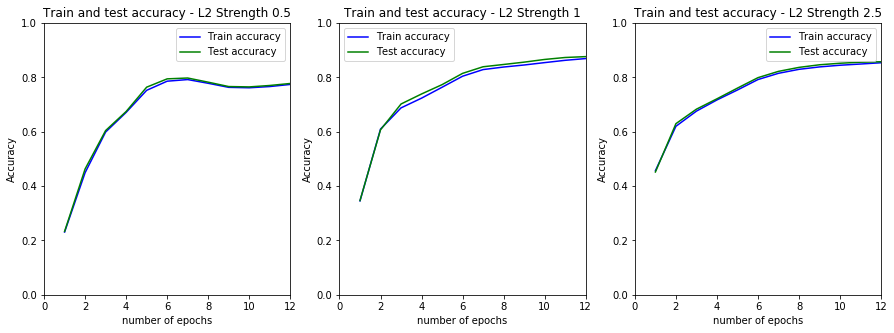

Last epoch of first plot:  Train accuracy 0.773945 Test accuracy 0.77750
Last epoch of second plot:  Train accuracy 0.869127 Test accuracy 0.87630
Last epoch of third plot:  Train accuracy 0.869127 Test accuracy 0.85750


In [57]:
#Plotting
plt.figure(figsize=(15,5))
K = range(1,13)

plt.subplot(1,3,1)
plt.plot(K, train_accuracy_1, color='blue', label='Train accuracy')
plt.plot(K, test_accuracy_1, color='green', label='Test accuracy')
plt.xlabel('number of epochs')
plt.ylabel('Accuracy')
plt.title('Train and test accuracy - L2 Strength 0.5')
plt.legend()
plt.axis([0, 12, 0, 1])

plt.subplot(1,3,2)
plt.plot(K, train_accuracy_2, color='blue', label='Train accuracy')
plt.plot(K, test_accuracy_2, color='green', label='Test accuracy')
plt.xlabel('number of epochs')
plt.ylabel('Accuracy')
plt.title('Train and test accuracy - L2 Strength 1')
plt.legend()
plt.axis([0, 12, 0, 1])


plt.subplot(1,3,3)
plt.plot(K, train_accuracy_3, color='blue', label='Train accuracy')
plt.plot(K, test_accuracy_3, color='green', label='Test accuracy')
plt.xlabel('number of epochs')
plt.ylabel('Accuracy')
plt.title('Train and test accuracy - L2 Strength 2.5')
plt.legend()
plt.axis([0, 12, 0, 1])
plt.show()

print("Last epoch of first plot:  Train accuracy {0:5f} Test accuracy {1:.5f}".format(train_accuracy_1[11],test_accuracy_1[11]))
print("Last epoch of second plot:  Train accuracy {0:5f} Test accuracy {1:.5f}".format(train_accuracy_2[11],test_accuracy_2[11]))
print("Last epoch of third plot:  Train accuracy {0:5f} Test accuracy {1:.5f}".format(train_accuracy_2[11],test_accuracy_3[11]))


Even tought the MLP with L2 strength of 2.5 converges faster at the beginning, it has same training accuracy like the MLP with L2 strength of 1.
But the test performance is more better at the seconds. Therefore, I'll continue with a L2 strength of 1

# 2 c) Performance with mini-batches

In [74]:
model = MLP(num_output = y_train.shape[1],
            num_features = X_train.shape[1],
            num_layers_0 = 128,
            num_layers_1 = 64,
            start_learning_rate = 0.001,
            activiation_method_hidden_layer = "tanh",
            l2_regulation_strength = 1)
sess = tf.Session(graph=model.g)


train_accuracy_1, train_cost_1, test_accuracy_1 = train_mlp(sess,model,X_train,y_train,X_test,y_test,
                                                       num_epochs = 12,
                                                       batch_size = 512)
print("Finished 1st Multilayer Perceptron")


train_accuracy_2, train_cost_2, test_accuracy_2 = train_mlp(sess,model,X_train,y_train,X_test,y_test,
                                                            num_epochs = 12,
                                                            batch_size = 256)

print("Finished 2nd Multilayer Perceptron")

train_accuracy_3, train_cost_3, test_accuracy_3 = train_mlp(sess,model,X_train,y_train,X_test,y_test,
                                                            num_epochs = 12,
                                                            batch_size = 64)

print("Finished 3rd Multilayer Perceptron")

Finished 1st Multilayer Perceptron
Finished 2nd Multilayer Perceptron
Finished 3rd Multilayer Perceptron


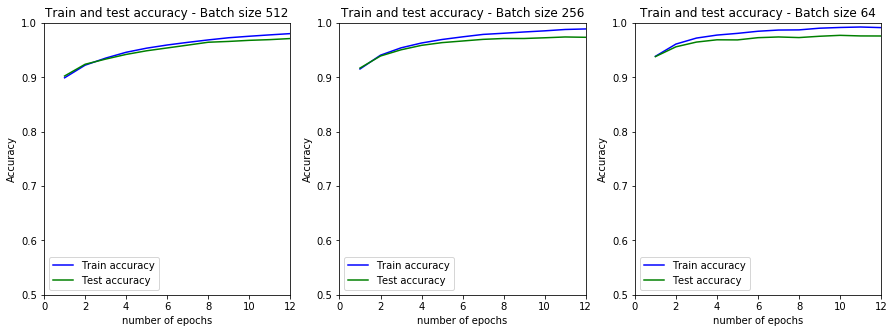

Last epoch of first plot:  Train accuracy 0.980473 Test accuracy 0.97140
Last epoch of second plot:  Train accuracy 0.989073 Test accuracy 0.97370
Last epoch of third plot:  Train accuracy 0.991527 Test accuracy 0.97610


In [79]:
#Plotting Accuracy
plt.figure(figsize=(15,5))
K = range(1,13)

plt.subplot(1,3,1)
plt.plot(K, train_accuracy_1, color='blue', label='Train accuracy')
plt.plot(K, test_accuracy_1, color='green', label='Test accuracy')
plt.xlabel('number of epochs')
plt.ylabel('Accuracy')
plt.title('Train and test accuracy - Batch size 512')
plt.legend()
plt.axis([0, 12, 0.5, 1])

plt.subplot(1,3,2)
plt.plot(K, train_accuracy_2, color='blue', label='Train accuracy')
plt.plot(K, test_accuracy_2, color='green', label='Test accuracy')
plt.xlabel('number of epochs')
plt.ylabel('Accuracy')
plt.title('Train and test accuracy - Batch size 256')
plt.legend()
plt.axis([0, 12, 0.5, 1])


plt.subplot(1,3,3)
plt.plot(K, train_accuracy_3, color='blue', label='Train accuracy')
plt.plot(K, test_accuracy_3, color='green', label='Test accuracy')
plt.xlabel('number of epochs')
plt.ylabel('Accuracy')
plt.title('Train and test accuracy - Batch size 64')
plt.legend()
plt.axis([0, 12, 0.5, 1])
plt.show()

print("Last epoch of first plot:  Train accuracy {0:5f} Test accuracy {1:.5f}".format(train_accuracy_1[11],test_accuracy_1[11]))
print("Last epoch of second plot:  Train accuracy {0:5f} Test accuracy {1:.5f}".format(train_accuracy_2[11],test_accuracy_2[11]))
print("Last epoch of third plot:  Train accuracy {0:5f} Test accuracy {1:.5f}".format(train_accuracy_3[11],test_accuracy_3[11]))


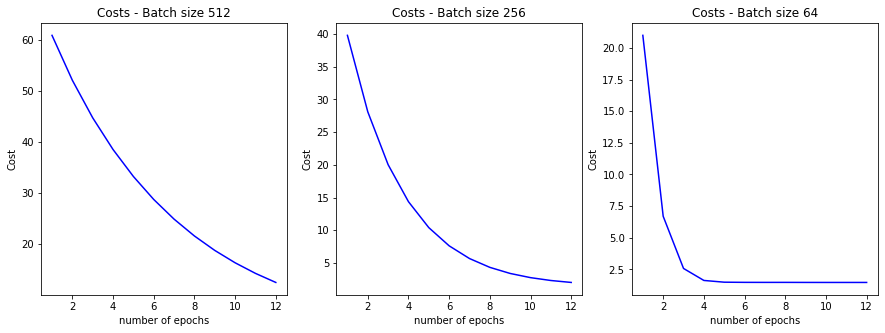

In [78]:
#Plotting Costs
plt.figure(figsize=(15,5))
K = range(1,13)

plt.subplot(1,3,1)
plt.plot(K, train_cost_1, color='blue', label='Costs/Loss')
plt.xlabel('number of epochs')
plt.ylabel('Cost')
plt.title('Costs - Batch size 512')

plt.subplot(1,3,2)
plt.plot(K, train_cost_2, color='blue', label='Costs/Loss')
plt.xlabel('number of epochs')
plt.ylabel('Cost')
plt.title('Costs - Batch size 256')

plt.subplot(1,3,3)
plt.plot(K, train_cost_3, color='blue', label='Costs/Loss')
plt.xlabel('number of epochs')
plt.ylabel('Cost')
plt.title('Costs - Batch size 64')
plt.show()

### Comment
As we can see, all 3 MLP converge much more faster in terms of accuracy compared to all pervious non-batch-versions. 
Note that the scale of y in the accuracy plot is changed, to see the lines more better.
We can see that with a higher batch size 512 the train and test accuracy don't tend to go as much apart from each other as in the MLP with smaller batch sizes. However, both accuracies are more higher in the MLP with the smallest batch size.

In the plot for the costs/loss, we can see that the costs decrease more faster if we decrease the batch size. This makes since, since the algorithm iterates more often within 1 epoch (total number of examples / batch-size). We can also see that the accuracy increases more faster in the algorithm with a smaller batch-size.